In [1]:
import os
os.environ['KAGGLE_USERNAME'] = "demiminjarez"
os.environ['KAGGLE_KEY'] = "71118f339b2ffe1143d9fec6ed72ebf7"

In [2]:
# imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score

In [3]:
from fastai.tabular.all import *
import torch.nn as nn


In [4]:
from torch.nn import BCEWithLogitsLoss


In [5]:
!kaggle datasets download -d wajahat1064/healthcare-appointment-dataset
# Unzip the downloaded file
!unzip -o healthcare-appointment-dataset.zip -d healthcare-appointment-dataset

Dataset URL: https://www.kaggle.com/datasets/wajahat1064/healthcare-appointment-dataset
License(s): apache-2.0
  0% 0.00/2.04M [00:00<?, ?B/s]
100% 2.04M/2.04M [00:00<00:00, 102MB/s]
Archive:  healthcare-appointment-dataset.zip
  inflating: healthcare-appointment-dataset/healthcare_noshows.csv  


In [6]:
def load_csv():
    current_dir = os.getcwd()
    csv_path = os.path.join(current_dir, 'healthcare-appointment-dataset', 'healthcare_noshows.csv')
    return pd.read_csv(csv_path)

In [7]:
# Load the data
df = load_csv()
df.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,Showed_up,Date.diff
0,2.987250e+13,5642903,F,2016-04-29,2016-04-29,62,JARDIM DA PENHA,False,True,False,False,False,False,True,0
1,5.589978e+14,5642503,M,2016-04-29,2016-04-29,56,JARDIM DA PENHA,False,False,False,False,False,False,True,0
2,4.262962e+12,5642549,F,2016-04-29,2016-04-29,62,MATA DA PRAIA,False,False,False,False,False,False,True,0
3,8.679512e+11,5642828,F,2016-04-29,2016-04-29,8,PONTAL DE CAMBURI,False,False,False,False,False,False,True,0
4,8.841186e+12,5642494,F,2016-04-29,2016-04-29,56,JARDIM DA PENHA,False,True,True,False,False,False,True,0


In [8]:
# Check for missing values
print("Missing values in each column:")
print(df.isnull().sum())

Missing values in each column:
PatientId         0
AppointmentID     0
Gender            0
ScheduledDay      0
AppointmentDay    0
Age               0
Neighbourhood     0
Scholarship       0
Hipertension      0
Diabetes          0
Alcoholism        0
Handcap           0
SMS_received      0
Showed_up         0
Date.diff         0
dtype: int64


In [9]:
df_model = df.copy()

In [10]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 106987 entries, 0 to 106986
Data columns (total 15 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   PatientId       106987 non-null  float64
 1   AppointmentID   106987 non-null  int64  
 2   Gender          106987 non-null  object 
 3   ScheduledDay    106987 non-null  object 
 4   AppointmentDay  106987 non-null  object 
 5   Age             106987 non-null  int64  
 6   Neighbourhood   106987 non-null  object 
 7   Scholarship     106987 non-null  bool   
 8   Hipertension    106987 non-null  bool   
 9   Diabetes        106987 non-null  bool   
 10  Alcoholism      106987 non-null  bool   
 11  Handcap         106987 non-null  bool   
 12  SMS_received    106987 non-null  bool   
 13  Showed_up       106987 non-null  bool   
 14  Date.diff       106987 non-null  int64  
dtypes: bool(7), float64(1), int64(3), object(4)
memory usage: 7.2+ MB


In [11]:
# Convert boolean columns to numeric
boolean_cols = ['Scholarship', 'Hipertension', 'Diabetes', 'Alcoholism', 'Handcap']
for col in boolean_cols:
    df_model[col] = df_model[col].astype(int)

df_model.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,Showed_up,Date.diff
0,2.987250e+13,5642903,F,2016-04-29,2016-04-29,62,JARDIM DA PENHA,0,1,0,0,0,False,True,0
1,5.589978e+14,5642503,M,2016-04-29,2016-04-29,56,JARDIM DA PENHA,0,0,0,0,0,False,True,0
2,4.262962e+12,5642549,F,2016-04-29,2016-04-29,62,MATA DA PRAIA,0,0,0,0,0,False,True,0
3,8.679512e+11,5642828,F,2016-04-29,2016-04-29,8,PONTAL DE CAMBURI,0,0,0,0,0,False,True,0
4,8.841186e+12,5642494,F,2016-04-29,2016-04-29,56,JARDIM DA PENHA,0,1,1,0,0,False,True,0


In [12]:
# Convert Showed_up from boolean to numeric (True -> 1, False -> 0)
df_model['Showed_up'] = df_model['Showed_up'].astype(int)
df_model.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,Showed_up,Date.diff
0,2.987250e+13,5642903,F,2016-04-29,2016-04-29,62,JARDIM DA PENHA,0,1,0,0,0,False,1,0
1,5.589978e+14,5642503,M,2016-04-29,2016-04-29,56,JARDIM DA PENHA,0,0,0,0,0,False,1,0
2,4.262962e+12,5642549,F,2016-04-29,2016-04-29,62,MATA DA PRAIA,0,0,0,0,0,False,1,0
3,8.679512e+11,5642828,F,2016-04-29,2016-04-29,8,PONTAL DE CAMBURI,0,0,0,0,0,False,1,0
4,8.841186e+12,5642494,F,2016-04-29,2016-04-29,56,JARDIM DA PENHA,0,1,1,0,0,False,1,0


In [13]:
# Convert Gender to numeric
df_model['Gender'] = df_model['Gender'].map({'F': 0, 'M': 1})
df_model.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,Showed_up,Date.diff
0,2.987250e+13,5642903,0,2016-04-29,2016-04-29,62,JARDIM DA PENHA,0,1,0,0,0,False,1,0
1,5.589978e+14,5642503,1,2016-04-29,2016-04-29,56,JARDIM DA PENHA,0,0,0,0,0,False,1,0
2,4.262962e+12,5642549,0,2016-04-29,2016-04-29,62,MATA DA PRAIA,0,0,0,0,0,False,1,0
3,8.679512e+11,5642828,0,2016-04-29,2016-04-29,8,PONTAL DE CAMBURI,0,0,0,0,0,False,1,0
4,8.841186e+12,5642494,0,2016-04-29,2016-04-29,56,JARDIM DA PENHA,0,1,1,0,0,False,1,0


In [14]:
# Convert SMS_received from boolean to numeric
df_model['SMS_received'] = df_model['SMS_received'].astype(int)
df_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 106987 entries, 0 to 106986
Data columns (total 15 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   PatientId       106987 non-null  float64
 1   AppointmentID   106987 non-null  int64  
 2   Gender          106987 non-null  int64  
 3   ScheduledDay    106987 non-null  object 
 4   AppointmentDay  106987 non-null  object 
 5   Age             106987 non-null  int64  
 6   Neighbourhood   106987 non-null  object 
 7   Scholarship     106987 non-null  int64  
 8   Hipertension    106987 non-null  int64  
 9   Diabetes        106987 non-null  int64  
 10  Alcoholism      106987 non-null  int64  
 11  Handcap         106987 non-null  int64  
 12  SMS_received    106987 non-null  int64  
 13  Showed_up       106987 non-null  int64  
 14  Date.diff       106987 non-null  int64  
dtypes: float64(1), int64(11), object(3)
memory usage: 12.2+ MB


In [15]:
df_model.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,Showed_up,Date.diff
0,2.987250e+13,5642903,0,2016-04-29,2016-04-29,62,JARDIM DA PENHA,0,1,0,0,0,0,1,0
1,5.589978e+14,5642503,1,2016-04-29,2016-04-29,56,JARDIM DA PENHA,0,0,0,0,0,0,1,0
2,4.262962e+12,5642549,0,2016-04-29,2016-04-29,62,MATA DA PRAIA,0,0,0,0,0,0,1,0
3,8.679512e+11,5642828,0,2016-04-29,2016-04-29,8,PONTAL DE CAMBURI,0,0,0,0,0,0,1,0
4,8.841186e+12,5642494,0,2016-04-29,2016-04-29,56,JARDIM DA PENHA,0,1,1,0,0,0,1,0


In [16]:
# Drop Neighbourhood column
df_model = df_model.drop('Neighbourhood', axis=1)

In [17]:
df_model.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,Showed_up,Date.diff
0,2.987250e+13,5642903,0,2016-04-29,2016-04-29,62,0,1,0,0,0,0,1,0
1,5.589978e+14,5642503,1,2016-04-29,2016-04-29,56,0,0,0,0,0,0,1,0
2,4.262962e+12,5642549,0,2016-04-29,2016-04-29,62,0,0,0,0,0,0,1,0
3,8.679512e+11,5642828,0,2016-04-29,2016-04-29,8,0,0,0,0,0,0,1,0
4,8.841186e+12,5642494,0,2016-04-29,2016-04-29,56,0,1,1,0,0,0,1,0


In [18]:
df_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 106987 entries, 0 to 106986
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   PatientId       106987 non-null  float64
 1   AppointmentID   106987 non-null  int64  
 2   Gender          106987 non-null  int64  
 3   ScheduledDay    106987 non-null  object 
 4   AppointmentDay  106987 non-null  object 
 5   Age             106987 non-null  int64  
 6   Scholarship     106987 non-null  int64  
 7   Hipertension    106987 non-null  int64  
 8   Diabetes        106987 non-null  int64  
 9   Alcoholism      106987 non-null  int64  
 10  Handcap         106987 non-null  int64  
 11  SMS_received    106987 non-null  int64  
 12  Showed_up       106987 non-null  int64  
 13  Date.diff       106987 non-null  int64  
dtypes: float64(1), int64(11), object(2)
memory usage: 11.4+ MB


In [19]:
# Calculate the difference in days between ScheduledDay and AppointmentDay
df_model['DaysUntilAppointment'] = (pd.to_datetime(df_model['AppointmentDay']) - pd.to_datetime(df_model['ScheduledDay'])).dt.days

# Extract the day of the week from AppointmentDay
df_model['AppointmentDayOfWeek'] = pd.to_datetime(df_model['AppointmentDay']).dt.dayofweek  # Monday=0, Sunday=6

# Drop the original date columns
df_model = df_model.drop(columns=['ScheduledDay', 'AppointmentDay'])

In [20]:
df_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 106987 entries, 0 to 106986
Data columns (total 14 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   PatientId             106987 non-null  float64
 1   AppointmentID         106987 non-null  int64  
 2   Gender                106987 non-null  int64  
 3   Age                   106987 non-null  int64  
 4   Scholarship           106987 non-null  int64  
 5   Hipertension          106987 non-null  int64  
 6   Diabetes              106987 non-null  int64  
 7   Alcoholism            106987 non-null  int64  
 8   Handcap               106987 non-null  int64  
 9   SMS_received          106987 non-null  int64  
 10  Showed_up             106987 non-null  int64  
 11  Date.diff             106987 non-null  int64  
 12  DaysUntilAppointment  106987 non-null  int64  
 13  AppointmentDayOfWeek  106987 non-null  int32  
dtypes: float64(1), int32(1), int64(12)
memory usage: 11.

In [21]:
df_model.corr()


,PatientId,AppointmentID,Gender,Age,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,Showed_up,Date.diff,DaysUntilAppointment,AppointmentDayOfWeek
PatientId,1.000000,0.004189,0.010440,-0.002970,-0.002172,-0.006155,0.001873,0.011361,-0.008748,-0.008468,0.001083,-0.000961,-0.000961,-0.001364
AppointmentID,0.004189,1.000000,0.020583,-0.023401,0.022379,0.012092,0.022505,0.033159,0.015006,-0.254682,0.161578,-0.772038,-0.772038,-0.051567
Gender,0.010440,0.020583,1.000000,-0.094108,-0.113679,-0.051312,-0.030027,0.110410,0.024599,-0.045852,0.003238,-0.030505,-0.030505,0.004179
Age,-0.002970,-0.023401,-0.094108,1.000000,-0.112699,0.502091,0.290631,0.090391,0.079726,0.005251,0.067025,0.038880,0.038880,0.000548
Scholarship,-0.002172,0.022379,-0.113679,-0.112699,1.000000,-0.024530,-0.027622,0.033527,-0.010465,-0.000010,-0.029370,-0.030439,-0.030439,-0.000780
Hipertension,-0.006155,0.012092,-0.051312,0.502091,-0.024530,1.000000,0.430827,0.085459,0.082909,-0.008805,0.037280,-0.016996,-0.016996,0.002716
Diabetes,0.001873,0.022505,-0.030027,0.290631,-0.027622,0.430827,1.000000,0.016874,0.057945,-0.016136,0.015928,-0.027339,-0.027339,0.006279
Alcoholism,0.011361,0.033159,0.110410,0.090391,0.033527,0.085459,0.016874,1.000000,0.002864,-0.027403,0.000517,-0.038949,-0.038949,0.002459
Handcap,-0.008748,0.015006,0.024599,0.079726,-0.010465,0.082909,0.057945,0.002864,1.000000,-0.026256,0.007620,-0.021101,-0.021101,0.004409
SMS_received,-0.008468,-0.254682,-0.045852,0.005251,-0.000010,-0.008805,-0.016136,-0.027403,-0.026256,1.000000,-0.127253,0.396482,0.396482,-0.092621


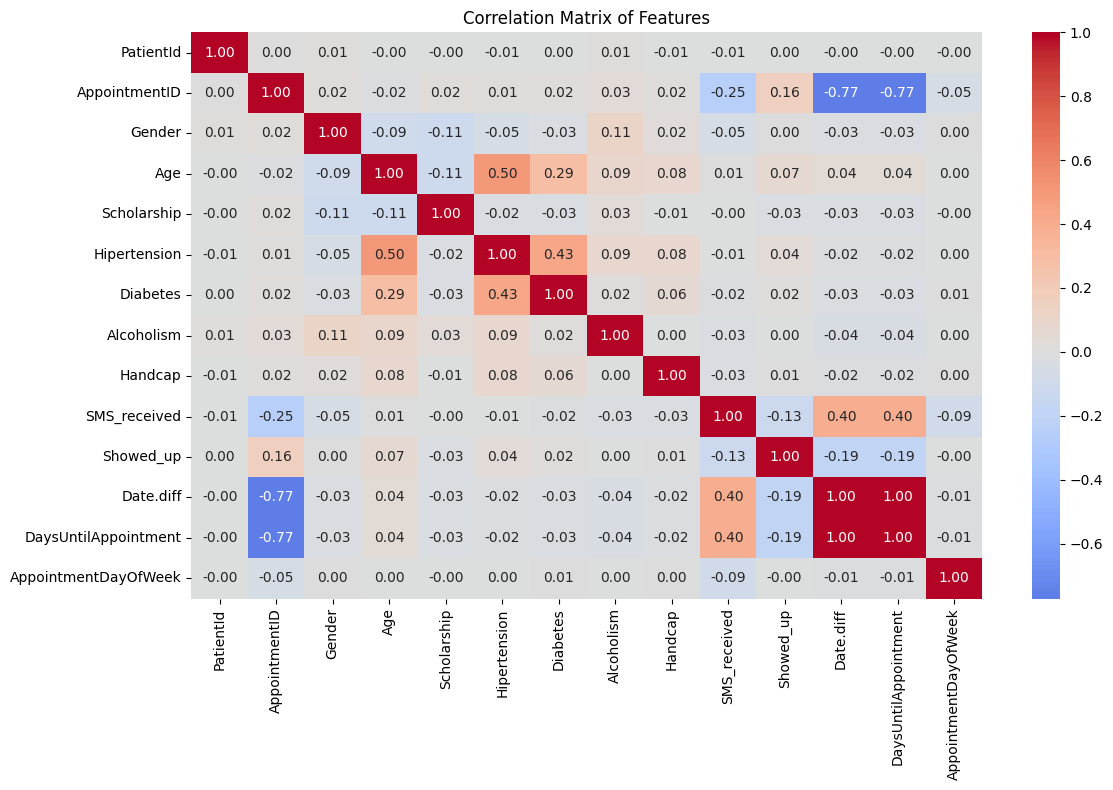

In [22]:
# Define correlation matrix
correlation_matrix = df_model.corr()

# Create the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix,
            annot=True,  # Show correlation values
            cmap='coolwarm',  # Color scheme
            center=0,  # Center the colormap at 0
            fmt='.2f')  # Round to 2 decimal places
plt.title('Correlation Matrix of Features')
plt.tight_layout()
plt.show()

In [23]:
# Removing redundant date difference column (keeping DaysUntilAppointment)
df_model = df_model.drop('Date.diff', axis=1)

# Dropping ID columns as they don't provide meaningful correlations
df_model = df_model.drop(['PatientId', 'AppointmentID'], axis=1)

In [24]:
# Keep all health-related variables
health_features = ['Age', 'Hipertension', 'Diabetes', 'Alcoholism', 'Handcap']


In [25]:
# Final feature set
print("Final features:", df_model.columns.tolist())

Final features: ['Gender', 'Age', 'Scholarship', 'Hipertension', 'Diabetes', 'Alcoholism', 'Handcap', 'SMS_received', 'Showed_up', 'DaysUntilAppointment', 'AppointmentDayOfWeek']


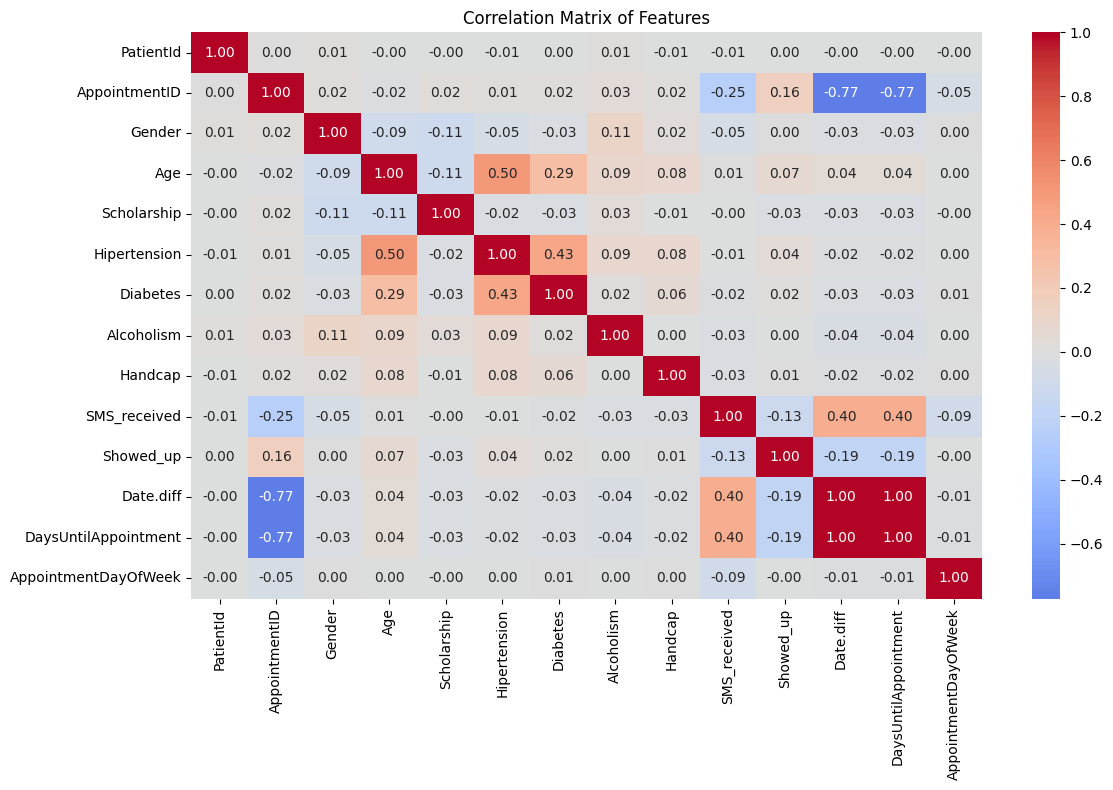

In [26]:
# Create the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix,
            annot=True,  # Show correlation values
            cmap='coolwarm',  # Color scheme
            center=0,  # Center the colormap at 0
            fmt='.2f')  # Round to 2 decimal places
plt.title('Correlation Matrix of Features')
plt.tight_layout()
plt.show()

In [27]:
# Define continuous and categorical variables
cont_vars = ['Age', 'DaysUntilAppointment']
cat_vars = ['Gender', 'Scholarship', 'Hipertension', 'Diabetes',
            'Alcoholism', 'Handcap', 'SMS_received', 'AppointmentDayOfWeek']


In [28]:
# Convert target variable to proper numeric type
df_model['Showed_up'] = df_model['Showed_up'].astype('float32')

In [29]:
# DataLoaders
data = TabularDataLoaders.from_df(
    df=df_model,
    cat_names=cat_vars,
    cont_names=cont_vars,
    y_names='Showed_up',
    valid_pct=0.2,           # 20% validation split
    bs=64,
    seed=42,
    procs=[Categorify, FillMissing, Normalize]
)

In [31]:
learn = tabular_learner(
    data,
    layers=[128, 64, 32],        # deeper network
    metrics=[accuracy, RocAucBinary()],
    loss_func=BCEWithLogitsLoss(),
    config=dict(ps=[0.2, 0.2, 0.2])  # correct way to specify dropout
)

/usr/local/lib/python3.10/dist-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_kwargs

SuggestedLRs(valley=0.010964781977236271)

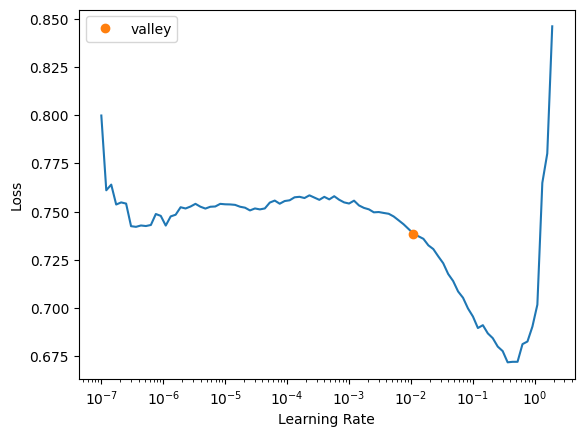

In [32]:
# Find optimal learning rate
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,roc_auc_score,time
0,0.592787,0.586456,0.202598,0.500000,00:23
1,0.459736,0.459514,0.202598,0.500000,00:19
2,0.456459,0.448988,0.202598,0.500000,00:15
3,0.448700,0.452267,0.202598,0.500000,00:19
4,0.450056,0.457336,0.202598,0.500000,00:31
5,0.455495,0.450454,0.202598,0.500000,00:19


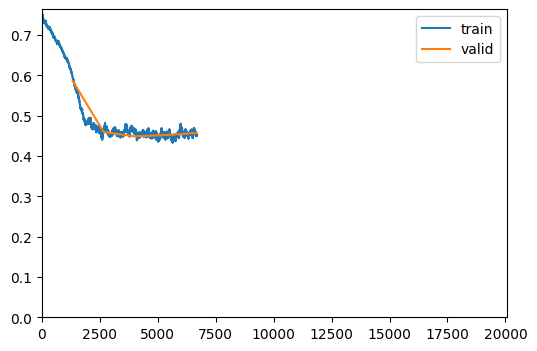

No improvement since epoch 2: early stopping


In [33]:
# Train the model
learn.fit_one_cycle(
    15,                     # number of epochs
    1e-3,                   # learning rate
    cbs=[
        ShowGraphCallback(),        # Shows training progress
        EarlyStoppingCallback(monitor='valid_loss', patience=3)  # Stops if not improving
    ]
)


In [34]:
# 3. View model performance
learn.show_results()

,Gender,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,AppointmentDayOfWeek,Age,DaysUntilAppointment,Showed_up,Showed_up_pred
0,2.0,1.0,2.0,1.0,1.0,1.0,1.0,5.0,1.812902,-0.534415,1.0,1.325988
1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.656337,-0.666304,1.0,2.739424
2,2.0,1.0,2.0,1.0,1.0,1.0,1.0,3.0,1.056686,-0.534415,1.0,1.344143
3,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.368069,-0.468471,1.0,1.198882
4,1.0,1.0,1.0,2.0,1.0,1.0,1.0,3.0,-0.277812,-0.666304,1.0,2.212914
5,1.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,1.368069,2.169316,1.0,1.256116
6,1.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,-1.256444,0.586644,0.0,0.687772
7,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.234619,2.499039,1.0,1.246904
8,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,-0.678161,-0.666304,1.0,2.176221


In [35]:


# Get predictions and calculate score
preds, targets = learn.get_preds()
print(f"ROC-AUC Score: {roc_auc_score(targets, preds):.4f}")

ROC-AUC Score: 0.7262
